Part 2: Implementation of a model based on VAE  
1. Dataset acquisition by merging the two databases. Exploration of the obtained dataset, including the selection of features of interest and image processing.  
2. Implementation of a VAE model using movie posters. After training the VAE, the model should be used for the generative sampling of new posters.  
3. Implementation of a cVAE model, conditioned on the movie genre. Extraction of movie genre information to be used as input for cVAE training. Generation of new movie posters conditioned on specific genres.


1. Dataset acquisition by merging the two databases.

In [ ]:
import pandas as pd
import os

# Define the paths to the MovieLens dataset and covers
movie_lens_path = "ml-25m"
covers_path = "covers"

# Load the MovieLens CSV files
movies = pd.read_csv(os.path.join(movie_lens_path, "movies.csv"))
ratings = pd.read_csv(os.path.join(movie_lens_path, "ratings.csv"))
links = pd.read_csv(os.path.join(movie_lens_path, "links.csv"))
tags = pd.read_csv(os.path.join(movie_lens_path, "tags.csv"))
genome_scores = pd.read_csv(os.path.join(movie_lens_path, "genome-scores.csv"))
genome_tags = pd.read_csv(os.path.join(movie_lens_path, "genome-tags.csv"))

# Load movie IDs and their corresponding cover file names
covers = os.listdir(covers_path)

# Create a dictionary to map movie IDs to cover file names
movie_cover_map = {}
for cover in covers:
    imdb_id = cover.split(".")[0]  # Remove the file extension
    movie_id = links[links['imdbId'] == int(imdb_id)]['movieId'].values[0]
    movie_cover_map[movie_id] = cover

# Verify an example
example_movie_id = 5

# Display the title of the movie with the ID of example_movie_id
print("The title of the movie with ID", example_movie_id, "is:", movies[movies['movieId'] == example_movie_id]['title'].values[0])
print("The cover file name for the movie with ID", example_movie_id, "is:", movie_cover_map[example_movie_id])

O título do filme com ID 5 é: Father of the Bride Part II (1995)
O nome do arquivo de capa para o filme com ID 5 é: 0113041.jpg


Exploração	 do	 dataset	 obtido	 incluindo	 seleção	 das	 features	 de	 interesse	e	processamento	das	imagens.

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId cover_filename  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0     114709.jpg  
1                   Adventure|Children|Fantasy  113497   8844.0     113497.jpg  
2                               Comedy|Romance  113228  15602.0     113228.jpg  
3                         Comedy|Drama|Romance  114885  31357.0     114885.jpg  
4                                       Comedy  113041  11862.0     113041.jpg  
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4   

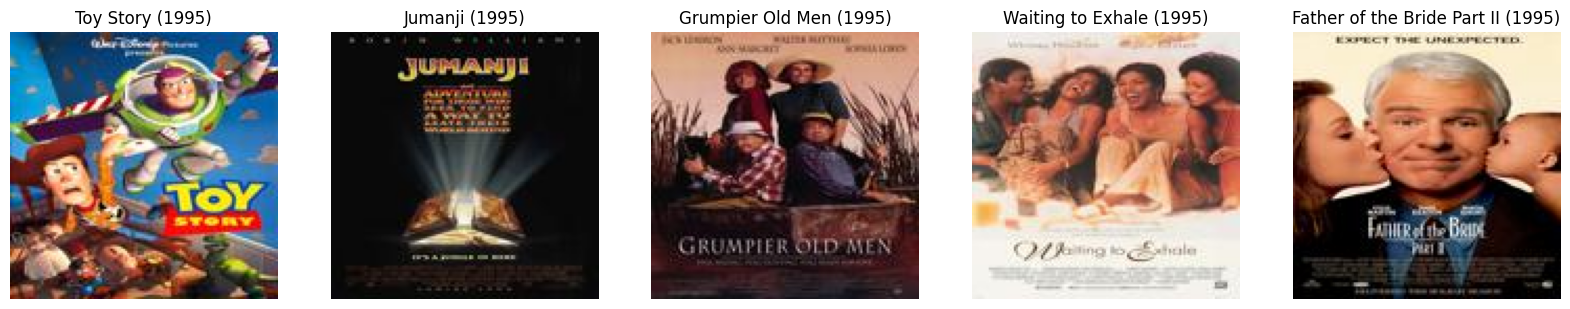

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Combine as informações dos filmes com os nomes dos arquivos de capa
movie_data = movies.merge(links, on='movieId')

# Adicione os nomes dos arquivos de capa ao dataset
movie_data['cover_filename'] = movie_data['imdbId'].astype(str) + '.jpg'

# Examine o dataset
print(movie_data.head())

# Seleção das features de interesse
features = ['movieId', 'title', 'genres', 'cover_filename']

# Examine as informações dos filmes e as primeiras imagens de capa
print(movie_data[features].head())


# Exemplo de carregamento e exibição de várias imagens
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(20, 20))
for i in range(num_images):
    movie_id = movie_data['movieId'].values[i]
    cover_filename = movie_cover_map[movie_id]
    cover_path = os.path.join(covers_path, cover_filename)
    cover = mpimg.imread(cover_path)
    axs[i].imshow(cover)
    axs[i].axis('off')
    axs[i].set_title(movie_data['title'].values[i])
plt.show()

In [23]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
drive_root = '/content/drive'

Mounted at /content/drive


2. Implementação do VAE

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import Callback,LearningRateScheduler

In [18]:
# Load das imagens
def load_data(data_path):

  images = []

  for filename in os.listdir(data_path):
    if filename.endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
      img = cv2.imread(os.path.join(data_path, filename))
      
      #este passo é necessário porque o OpenCV lê as imagens em BGR e não RGB, 
      converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      #Normalização para valores 0 e 1, + fácil para trabalhar numa rede
      converted_img = converted_img.astype(np.float32) / 255.0
      images.append(converted_img)

  images = np.array(images)
  return images

In [19]:

tf.compat.v1.disable_eager_execution() #Necessário para o Keras funcionar com o TF 2.0

def exponential_decay_schedule(initial_lr=1e-3, decay_rate=0.9): #Decaimento exponencial da learning rate
  
    def schedule(epoch):
        return initial_lr * decay_rate ** epoch #Decaimento da learning rate a cada epoch

    return LearningRateScheduler(schedule) #Callback do Keras para alterar a learning rate

class beta_scheduler(Callback):   #Classe para alterar o valor de beta a cada epoch
    def __init__(self, baseline_beta, total_epochs=5): 
        super(beta_scheduler, self).__init__()
        self.baseline_beta = baseline_beta #Valor inicial de beta   
        self.total_epochs = total_epochs
        self.beta = baseline_beta

    def on_epoch_end(self,epoch,logs=None): #Função para alterar o valor de beta a cada epoch 
        self.beta = 1/(1+np.exp((self.total_epochs/2)-epoch)) 

class VariationalAutoencoder(): #Classe para o VAE
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,   #Inicialização da classe
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size
                 , decoder_conv_t_strides, z_dim, num_classes):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters #Número de filtros em cada camada convolucional
        self.encoder_conv_kernel_size = encoder_conv_kernel_size #Kernel size = tamanho da matriz que percorre a imagem de entrada
        self.encoder_conv_strides = encoder_conv_strides #Strides = passos da matriz que percorre a imagem
        self.decoder_conv_t_filters = decoder_conv_t_filters #Número de filtros em cada camada convolucional transposta
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size #Kernel size = tamanho da matriz que percorre a imagem de saída
        self.decoder_conv_t_strides = decoder_conv_t_strides #Strides = passos da matriz que percorre a imagem
        self.z_dim = z_dim #Dimensão do vetor latente
        self.num_classes = num_classes #Número de classes

        self.n_layers_encoder = len(encoder_conv_filters) #Número de camadas convolucionais no encoder
        self.n_layers_decoder = len(decoder_conv_t_filters) #Número de camadas convolucionais transpostas no decoder

        self.build()

    def build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input') #Input layer do encoder 

        x = encoder_input

        for i in range(self.n_layers_encoder): #Loop para criar as camadas convolucionais do encoder 
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x) #Adiciona a camada convolucional ao modelo

            x = LeakyReLU()(x) #Adiciona a função de ativação LeakyReLU à camada convolucional 

        shape_before_flattening = K.int_shape(x)[1:] #Guarda a forma da imagem antes de ser achatada

        x = Flatten()(x) #Achata a imagem

        self.mu = Dense(self.z_dim, name='mu')(x) #Cria a camada densa para a média do vetor latente
        self.log_var = Dense(self.z_dim, name='log_var')(x) #Cria a camada densa para o logaritmo da variância do vetor latente

        encoder_output = Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var]) #Cria a camada de output do encoder com a função de sampling 

        self.encoder = Model(encoder_input, encoder_output) #Cria o modelo do encoder 


        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input') #Input layer do decoder

        x = Dense(np.prod(shape_before_flattening))(decoder_input) #Cria a camada densa do decoder com a forma da imagem antes de ser achatada 
        x = Reshape(shape_before_flattening)(x) #Recria a forma da imagem antes de ser achatada 

        for i in range(self.n_layers_decoder): #Loop para criar as camadas convolucionais transpostas do decoder 
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x) #Adiciona a camada convolucional transposta ao modelo 

            if i < self.n_layers_decoder - 1: #Adiciona a função de ativação LeakyReLU a todas as camadas exceto a última 

                x = LeakyReLU()(x)

            else:
                x = Activation('sigmoid')(x) #Adiciona a função de ativação sigmoid à última camada para obter valores entre 0 e 1

        decoder_output = x #Output layer do decoder 

        self.decoder = Model(decoder_input, decoder_output) #Cria o modelo do decoder 

        # FULL VAE
        model_input = encoder_input #Input layer do modelo VAE 
        model_output = self.decoder(encoder_output) #Output layer do modelo VAE 

        self.model = Model(model_input, model_output) #Cria o modelo VAE 

    def sampling(self,args): #Função de sampling para a camada de output do encoder 
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon #Retorna a média + desvio padrão * epsilon 

    def compile_model(self, learning_rate, r_loss_factor, betascheduler): #Compila o modelo VAE
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3]) #Calcula a loss de reconstrução 
            return  r_loss  * r_loss_factor 

        def vae_kl_loss(a, b): 
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1) #Calcula a loss de KL 
            return kl_loss*betascheduler.beta

        def vae_loss(y_true, y_pred):    #Calcula a loss total do modelo VAE 
            r_loss = vae_r_loss(y_true, y_pred) 
            kl_loss = vae_kl_loss(y_true, y_pred) 
            return  r_loss + kl_loss #Loss total = loss de reconstrução + loss de KL 

        optimizer = Adam(learning_rate=learning_rate) #Otimizador Adam com a learning rate definida 
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss]) #Compila o modelo com a loss total e as métricas de reconstrução e KL 


    def train(self, x_train, batch_size, epochs, print_history_bool = True, lr_decay = 0.9): #Função para treinar o modelo VAE com os dados de treino e learnig rate de decay de 0.9

        lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_rate=lr_decay)

        callbacks_list = [lr_sched]

        history = self.model.fit(x_train, x_train, batch_size = batch_size, shuffle = True,
                       epochs = epochs, callbacks = callbacks_list) #Treina o modelo VAE 

        if print_history: #Mostra a progressão da loss ao longo das epochs 
            plt.plot(history.history['loss'])
            plt.plot(history.history['vae_r_loss'])
            plt.plot(history.history['vae_kl_loss'])
            plt.title('Loss progression')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['VAE loss', 'Reconstruction', 'KL'], loc='upper right')
            plt.show()
        return history #Retorna o histórico de treino 

In [20]:
covers_dir = '/content/drive/MyDrive/content/covers_100'
images = load_data(covers_dir)

In [21]:
len(images) #Número de imagens carregadas, apenas 1000 pois o Google Colab não estava a suportar mais e o tempo de treino era muito elevado

1001

In [22]:

X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)  #Divide o dataset em treino e teste com 80% para treino e 20% para teste

# Print shapes to confirm the split
print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape)

X_train shape: (800, 128, 128, 3)
X_test shape: (201, 128, 128, 3)


In [23]:
vae = VariationalAutoencoder( #Cria o modelo VAE com os parâmetros definidos 
    input_dim = (128,128,3) #Dimensão da imagem de entrada escolhemos 128x128x3 pois é o tamanho das imagens carregadas
    , encoder_conv_filters = [32,64,64,64] #Número de filtros em cada camada convolucional do encoder 
    , encoder_conv_kernel_size = [3,3,3,3] #Kernel size em cada camada convolucional do encoder 
    , encoder_conv_strides = [1,2,2,1] #Strides em cada camada convolucional do encoder 
    , decoder_conv_t_filters = [64,64,32,1] #Número de filtros em cada camada convolucional transposta do decoder
    , decoder_conv_t_kernel_size = [3,3,3,3] #Kernel size em cada camada convolucional transposta do decoder
    , decoder_conv_t_strides = [1,2,2,1] #Strides em cada camada convolucional transposta do decoder
    , z_dim = 2
    , num_classes = 19
)

vae.encoder.summary()
vae.decoder.summary()

# Setting the parameters
learning_rate = 0.0005  #Learning rate escolhida pois é um valor comum para otimizadores Adam 
reconstruction_loss_factor = 100  #Fator de loss de reconstrução escolhido para 100 pois é um valor comum para VAEs
batch_size = 32  #Tamanho do batch escolhido para 32 pois é um valor comum para treino de nn
epochs = 25 #Número de epochs escolhido para 25 pois é um valor comum para treino de nn
print_history = True
baseline_beta =  0.2 #Valor inicial de beta escolhido para 0.2 pois é um valor comum para VAEs

betascheduler = beta_scheduler(baseline_beta =  0.2, total_epochs = 25) #Cria o scheduler de beta com o valor inicial de 0.2 e 25 epochs totais

vae.compile_model(learning_rate, reconstruction_loss_factor,betascheduler) #Compila o modelo VAE com os parâmetros definidos

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 32)         0         ['encoder_conv_0[0][0]']      
                                                                                                  
 encoder_conv_1 (Conv2D)     (None, 64, 64, 64)           18496     ['leaky_re_lu_7[0][0]']       
                                                                                            

Train on 800 samples
Epoch 1/25
800/800 [==============================] - 60s 75ms/sample - loss: 10.1997 - vae_r_loss: 10.1739 - vae_kl_loss: 0.0257 - lr: 5.0000e-04
Epoch 2/25
800/800 [==============================] - 61s 76ms/sample - loss: 10.0728 - vae_r_loss: 10.0691 - vae_kl_loss: 0.0036 - lr: 4.5000e-04
Epoch 3/25
800/800 [==============================] - 63s 79ms/sample - loss: 9.9493 - vae_r_loss: 9.9050 - vae_kl_loss: 0.0443 - lr: 4.0500e-04
Epoch 4/25
800/800 [==============================] - 62s 78ms/sample - loss: 9.0280 - vae_r_loss: 8.6759 - vae_kl_loss: 0.3520 - lr: 3.6450e-04
Epoch 5/25
800/800 [==============================] - 57s 72ms/sample - loss: 8.2925 - vae_r_loss: 7.8524 - vae_kl_loss: 0.4400 - lr: 3.2805e-04
Epoch 6/25
800/800 [==============================] - 59s 74ms/sample - loss: 8.0615 - vae_r_loss: 7.5535 - vae_kl_loss: 0.5079 - lr: 2.9525e-04
Epoch 7/25
800/800 [==============================] - 58s 72ms/sample - loss: 7.9389 - vae_r_loss: 7.4601

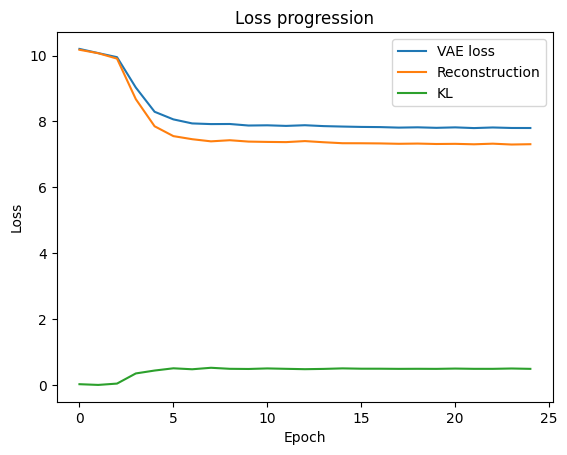

In [24]:
history = vae.train(X_train, batch_size = batch_size, epochs = epochs,
                     print_history_bool= print_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


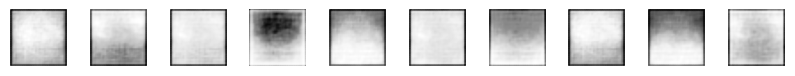

In [25]:
n_to_test = 10 #Número de imagens para mostrar
example_idx = np.random.choice(range(len(X_test)), n_to_test) #Escolhe aleatoriamente 10 imagens das imagens de teste 
example_images = X_test[example_idx] #Guarda as imagens escolhidas
reconst = vae.model.predict(example_images) #Reconstrói as imagens escolhidas

fig = plt.figure(figsize=(10, 2)) #Cria a figura para mostrar as imagens
fig.subplots_adjust(hspace=0.4, wspace=0.4) #Espaçamento entre as imagens
for i in range(n_to_test): #Loop para mostrar as imagens criadas pelo VAE
    ax = fig.add_subplot(1, n_to_test, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

3. Implementação do cVae

In [32]:
#Concatenação dos csv importantes para esta parte, filmes, links e ratings e criação de um dataset com as informações necessárias

df1= pd.read_csv("/content/drive/MyDrive/content/ml-25m/movies.csv")
df2= pd.read_csv("/content/drive/MyDrive/content/ml-25m/links.csv")
df3=pd.read_csv("/content/drive/MyDrive/content/ml-25m/ratings.csv")

df4 = df3.groupby('movieId')['rating'].mean()
df = pd.merge(df1, df2, on='movieId', how='inner')
dF=pd.merge(df, df4, on='movieId', how='inner')



In [33]:
dF.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId    rating  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  3.893708  
1                   Adventure|Children|Fantasy  113497   8844.0  3.251527  
2                               Comedy|Romance  113228  15602.0  3.142028  
3                         Comedy|Drama|Romance  114885  31357.0  2.853547  
4                                       Comedy  113041  11862.0  3.058434

In [34]:
dF["genres"] = df["genres"].str.split("|").str.get(0)

In [35]:
dFinal = dF.copy()
dFinal

movieId                               title     genres   imdbId  \
0            1                    Toy Story (1995)  Adventure   114709   
1            2                      Jumanji (1995)  Adventure   113497   
2            3             Grumpier Old Men (1995)     Comedy   113228   
3            4            Waiting to Exhale (1995)     Comedy   114885   
4            5  Father of the Bride Part II (1995)     Comedy   113041   
...        ...                                 ...        ...      ...   
59042   209157                           We (2018)      Drama  6671244   
59043   209159           Window of the Soul (2001)      Drama   297986   
59044   209163                    Bad Poems (2018)      Drama  6755366   
59045   209169                 A Girl Thing (2001)      Drama   249603   
59046   209171      Women of Devil's Island (1962)     Horror    55323   

         tmdbId    rating  
0         862.0  3.893708  
1        8844.0  3.251527  
2       15602.0  3.142028  
3       31357.0  2.853547  
4       11862.0  3.058434  
...         ...       ...  
59042  499546.0  1.500000  
59043   63407.0  3.000000  
59044  553036.0  4.500000  
59045  162892.0  3.000000  
59046   79513.0  3.000000  

[59047 rows x 6 columns]

In [36]:
import re

def load_data(data_path, df):

    # ligar os dados das imagens com os dados dos filmes carrergados
    
    images = []
    genres = []

    for filename in os.listdir(data_path):
        if filename.endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
            match = re.search(r'\d+', filename)
            if match:
                imdbId = int(match.group())
                if imdbId in df['imdbId'].values:
                    img = cv2.imread(os.path.join(data_path, filename))
                    converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    converted_img = converted_img.astype(np.float32) / 255.0
                    images.append(converted_img)
                    genre = df.loc[df['imdbId'] == imdbId, ['genres']].values[0]
                    genres.append(genre)
                else:
                    print(f"No entry found for imdbId {imdbId}")
            else:
                print(f"Unable to extract imdbId from filename {filename}")

    images = np.array(images)
    genres = np.array(genres)
    return images, genres

In [37]:
from tensorflow.keras.layers import Concatenate
tf.compat.v1.disable_eager_execution()

def exponential_decay_schedule(initial_lr=1e-3, decay_rate=0.9): #Decaimento exponencial da learning rate 
    def schedule(epoch):
        return initial_lr * decay_rate ** epoch
    return LearningRateScheduler(schedule) 

class beta_scheduler(Callback):
    def __init__(self, baseline_beta, total_epochs=5):
        super(beta_scheduler, self).__init__()
        self.baseline_beta = baseline_beta
        self.total_epochs = total_epochs
        self.beta = baseline_beta

    def on_epoch_end(self, epoch, logs=None):
        self.beta = 1/(1+np.exp((self.total_epochs/2)-epoch))

class ConditionalVariationalAutoencoder(): #Classe para o cVAE
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, 
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size, 
                 decoder_conv_t_strides, z_dim, num_classes):

        self.input_dim = input_dim #Dimensão da imagem de entrada
        self.encoder_conv_filters = encoder_conv_filters #Número de filtros em cada camada convolucional do encoder
        self.encoder_conv_kernel_size = encoder_conv_kernel_size #Kernel size em cada camada convolucional do encoder
        self.encoder_conv_strides = encoder_conv_strides #Strides em cada camada convolucional do encoder
        self.decoder_conv_t_filters = decoder_conv_t_filters #Número de filtros em cada camada convolucional transposta do decoder
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size #Kernel size em cada camada convolucional transposta do decoder
        self.decoder_conv_t_strides = decoder_conv_t_strides #Strides em cada camada convolucional transposta do decoder
        self.z_dim = z_dim #Dimensão do vetor latente
        self.num_classes = num_classes #Número de classes

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.build()

    def build(self):
        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')
        label_input = Input(shape=(self.num_classes,), name='label_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i],
                kernel_size=self.encoder_conv_kernel_size[i],
                strides=self.encoder_conv_strides[i],
                padding='same',
                name='encoder_conv_' + str(i)
            )
            x = conv_layer(x)
            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)

        x = Concatenate()([x, label_input])

        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        encoder_output = Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model([encoder_input, label_input], encoder_output)

        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        decoder_label_input = Input(shape=(self.num_classes,), name='decoder_label_input')

        x = Concatenate()([decoder_input, decoder_label_input])
        x = Dense(np.prod(shape_before_flattening))(x)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder): #Loop para criar as camadas convolucionais transpostas do decoder 
            conv_t_layer = Conv2DTranspose(
                filters=self.decoder_conv_t_filters[i],
                kernel_size=self.decoder_conv_t_kernel_size[i],
                strides=self.decoder_conv_t_strides[i],
                padding='same',
                name='decoder_conv_t_' + str(i)
            )
            x = conv_t_layer(x) #Adiciona a camada convolucional transposta ao modelo 

            if i < self.n_layers_decoder - 1: #Adiciona a função de ativação LeakyReLU a todas as camadas exceto a última 
                x = LeakyReLU()(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x  # Output layer do decoder 
 
        self.decoder = Model([decoder_input, decoder_label_input], decoder_output)

        # FULL cVAE
        model_input = [encoder_input, label_input] #Input layer do modelo cVAE 
        model_output = self.decoder([encoder_output, label_input]) #Output layer do modelo cVAE

        self.model = Model(model_input, model_output)

    def sampling(self, args): #Função de sampling para a camada de output do encoder 
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.) #Cria um vetor epsilon com valores aleatórios, com a mesma forma que a média 
        return mu + K.exp(log_var / 2) * epsilon #Retorna a média + desvio padrão * epsilon

    def compile_model(self, learning_rate, r_loss_factor, betascheduler):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]) #Calcula a loss de reconstrução, a média do quadrado da diferença entre a imagem original e a reconstruída
            return r_loss * r_loss_factor

        def vae_kl_loss(a, b):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1) #Calcula a loss de KL, a divergência de Kullback-Leibler entre a distribuição latente e a distribuição normal padrão 
            return kl_loss * betascheduler.beta

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred) #Calcula a loss de reconstrução
            kl_loss = vae_kl_loss(y_true, y_pred) #Calcula a loss de KL
            return r_loss + kl_loss #Loss total = loss de reconstrução + loss de KL

        optimizer = Adam(learning_rate=learning_rate) 
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss]) #Compila o modelo com a loss total e as métricas de reconstrução e KL, usando o otimizador Adam e a learning rate definida 

    def train(self, x_train, y_train, batch_size, epochs, print_history_bool=True, lr_decay=0.9):
        lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_rate=lr_decay)
        callbacks_list = [lr_sched]

        history = self.model.fit([x_train, y_train], x_train, batch_size=batch_size, shuffle=True,
                                 epochs=epochs, callbacks=callbacks_list)

        if print_history_bool: #Mostra a progressão da loss ao longo das epochs
            plt.plot(history.history['loss'])
            plt.plot(history.history['vae_r_loss'])
            plt.plot(history.history['vae_kl_loss'])
            plt.title('Loss progression')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['VAE loss', 'Reconstruction', 'KL'], loc='upper right')
            plt.show()
        return history

In [38]:
images, genres = load_data(covers_dir, dFinal) #Carrega as imagens e os géneros dos filmes, como o dataset é grande, apenas 1000 imagens foram carregadas

No entry found for imdbId 1388
No entry found for imdbId 6145
No entry found for imdbId 12408
No entry found for imdbId 10466
No entry found for imdbId 11348
No entry found for imdbId 14605
No entry found for imdbId 13402
No entry found for imdbId 14811
No entry found for imdbId 14760
No entry found for imdbId 16871
No entry found for imdbId 17029
No entry found for imdbId 16258
No entry found for imdbId 16787
No entry found for imdbId 16829
No entry found for imdbId 16129
No entry found for imdbId 17382
No entry found for imdbId 17735
No entry found for imdbId 17438
No entry found for imdbId 17929
No entry found for imdbId 17632
No entry found for imdbId 18187
No entry found for imdbId 18464
No entry found for imdbId 17860
No entry found for imdbId 18678
No entry found for imdbId 19640
No entry found for imdbId 18749
No entry found for imdbId 19726
No entry found for imdbId 19434
No entry found for imdbId 19688
No entry found for imdbId 18588
No entry found for imdbId 19976
No entry f

In [39]:
len(images) #Número de imagens carregadas, após a ligaçao com os dados dos filmes

922

In [40]:

genres = pd.get_dummies(genres.flatten()).values #Transforma os géneros dos filmes em one-hot encoding, para serem usados como labels, para cada género é criada uma coluna com 0 ou 1(binário) baseado no género do filme

X_train, X_test, y_train, y_test = train_test_split(images, genres, test_size=0.2, random_state=42) #Divide o dataset em treino e teste com 80% para treino e 20% para teste 

# Print das shapes para confirmar a divisão
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (737, 128, 128, 3)
X_test shape: (185, 128, 128, 3)
y_train shape: (737, 19)
y_test shape: (185, 19)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 32)         0         ['encoder_conv_0[0][0]']      
                                                                                                  
 encoder_conv_1 (Conv2D)     (None, 64, 64, 64)           18496     ['leaky_re_lu_7[0][0]']       
                                                                                            

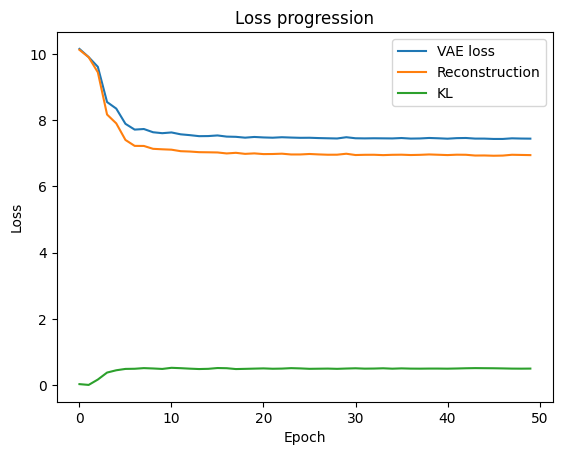

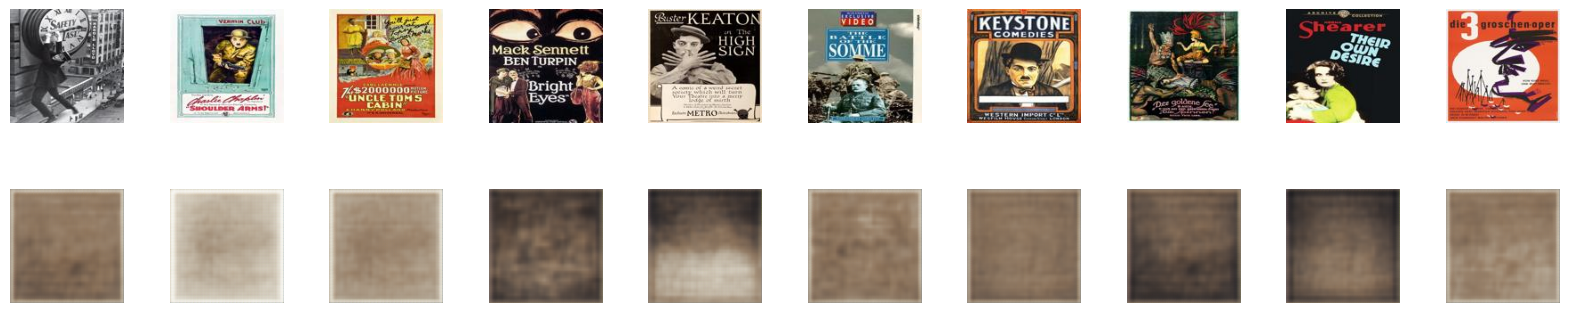

In [43]:
cvae = ConditionalVariationalAutoencoder( #Cria o modelo cVAE com os parâmetros definidos
    input_dim=(128, 128, 3), #Dimensão da imagem de entrada escolhemos 128x128x3 novamente
    encoder_conv_filters=[32, 64, 64, 64], #Número de filtros em cada camada convolucional do encoder, valores comuns para VAEs
    encoder_conv_kernel_size=[3, 3, 3, 3], #Kernel size em cada camada convolucional do encoder, valores comuns para VAEs
    encoder_conv_strides=[1, 2, 2, 1], #Strides em cada camada convolucional do encoder, valores comuns para VAEs
    decoder_conv_t_filters=[64, 64, 32, 3], #Número de filtros em cada camada convolucional transposta do decoder, valores comuns para VAEs
    decoder_conv_t_kernel_size=[3, 3, 3, 3], #Kernel size em cada camada convolucional transposta do decoder, valores comuns para VAEs
    decoder_conv_t_strides=[1, 2, 2, 1], #Strides em cada camada convolucional transposta do decoder, valores comuns para VAEs
    z_dim=2, #Dimensão do vetor latente, valor comum para VAEs
    num_classes=y_train.shape[1] #Número de classes = número de géneros, neste caso 19
)

cvae.encoder.summary()
cvae.decoder.summary()

# Setting the parameters
learning_rate = 0.0005 #Learning rate escolhida pois é um valor comum para otimizadores Adam
reconstruction_loss_factor = 100 #Fator de loss de reconstrução escolhido para 100 pois é um valor com um bom compromisso entre a loss de reconstrução e a loss de KL e não é muito elevado
batch_size = 32 #Tamanho do batch escolhido para 32 pois menos que isso pode ser muito lento e mais que isso pode não ser eficaz
epochs = 50 #Número de epochs escolhido para 50, 25 pode ser pouco para o modelo aprender bem e 100 demora muito tempo
print_history = True
baseline_beta = 0.2 #Valor inicial de beta escolhido

betascheduler = beta_scheduler(baseline_beta=0.2, total_epochs=50)

cvae.compile_model(learning_rate, reconstruction_loss_factor, betascheduler)

history = cvae.train(X_train, y_train, batch_size=batch_size, epochs=epochs, print_history_bool=print_history)

n_to_test = 10 #Número de imagens para mostrar novamente
example_idx = np.random.choice(range(len(X_test)), n_to_test) #Escolhe aleatoriamente 10 imagens das imagens de teste
example_images = X_test[example_idx] #Guarda as imagens escolhidas
example_labels = y_test[example_idx] #Guarda as labels das imagens escolhidas
reconst = cvae.model.predict([example_images, example_labels]) #Reconstrói as imagens escolhidas

fig = plt.figure(figsize=(20, 4)) #Cria a figura para mostrar as imagens
fig.subplots_adjust(hspace=0.4, wspace=0.4) #Espaçamento entre as imagens
for i in range(n_to_test): #Loop para mostrar as imagens criadas pelo cVAE
    ax = fig.add_subplot(2, n_to_test, i+1)
    ax.axis('off')
    ax.imshow(example_images[i])
    ax = fig.add_subplot(2, n_to_test, n_to_test + i + 1)
    ax.axis('off')
    ax.imshow(reconst[i])
plt.show()

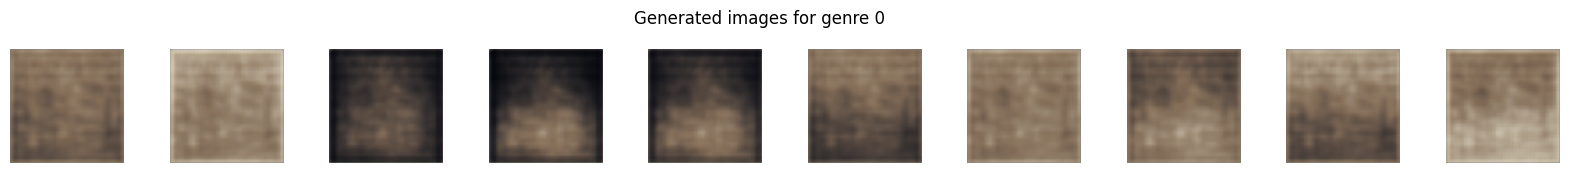

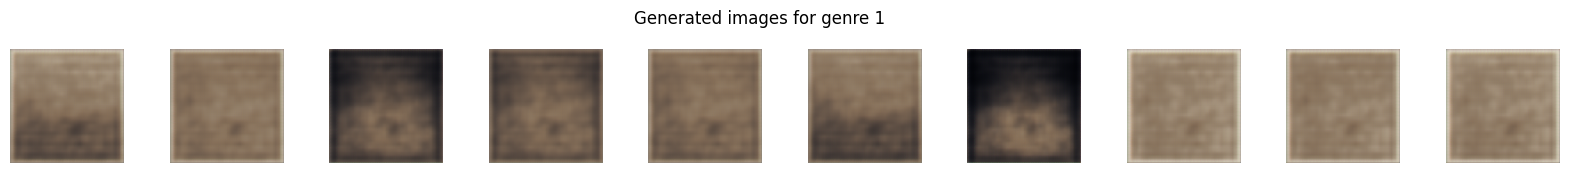

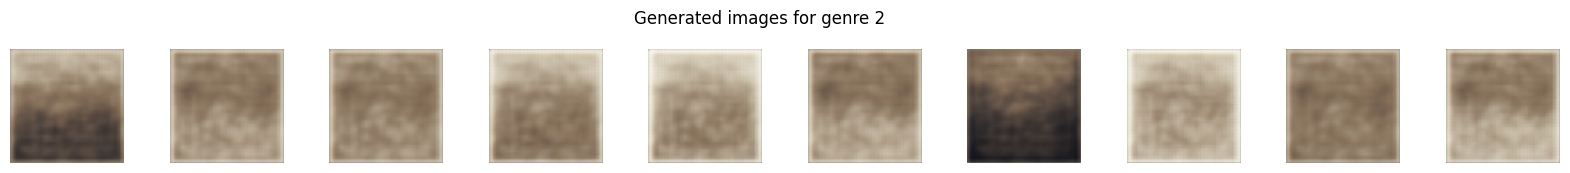

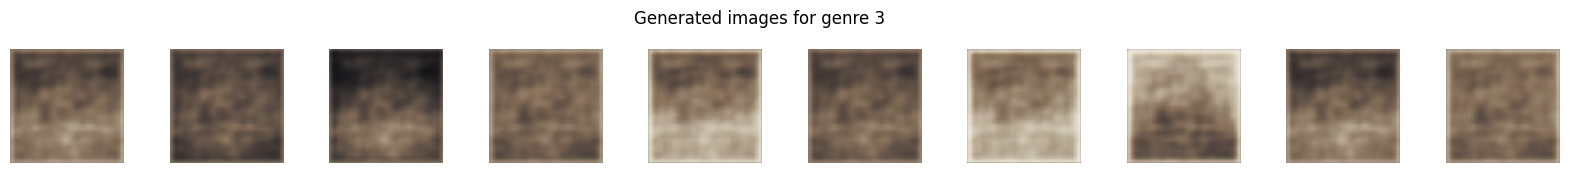

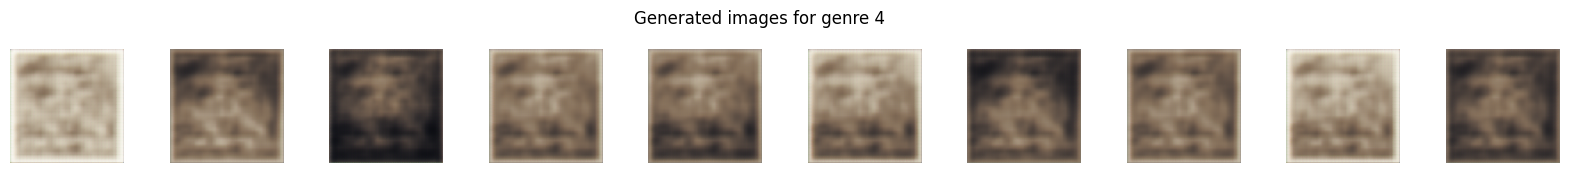

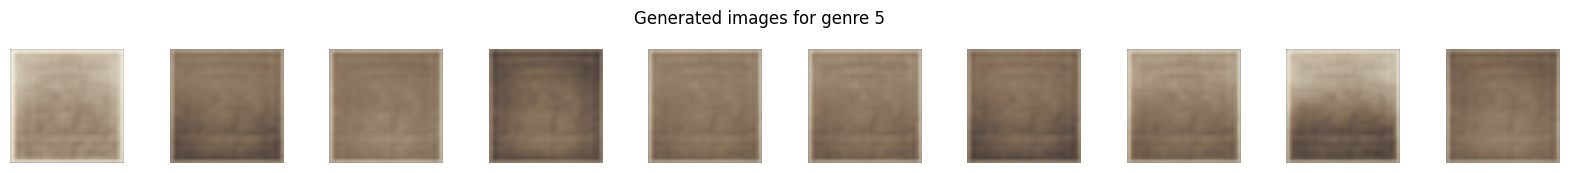

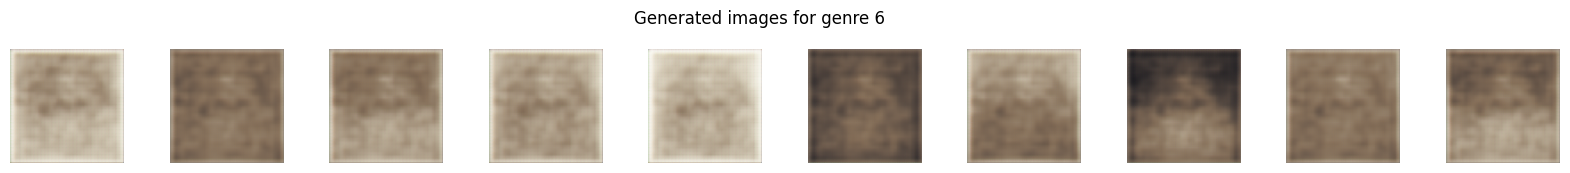

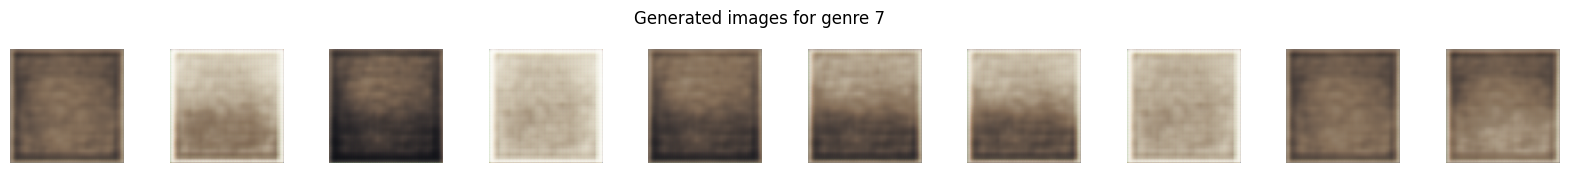

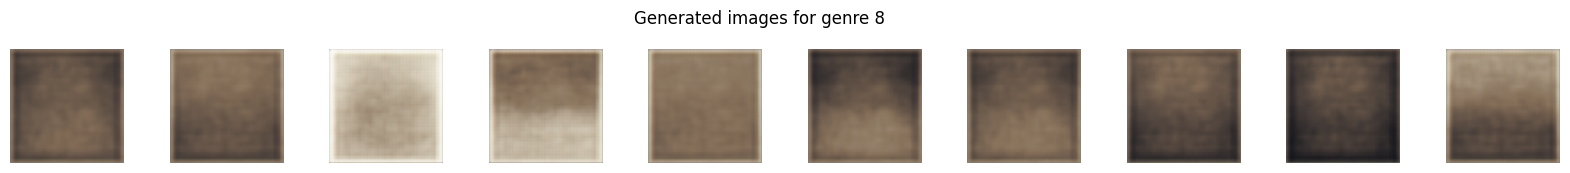

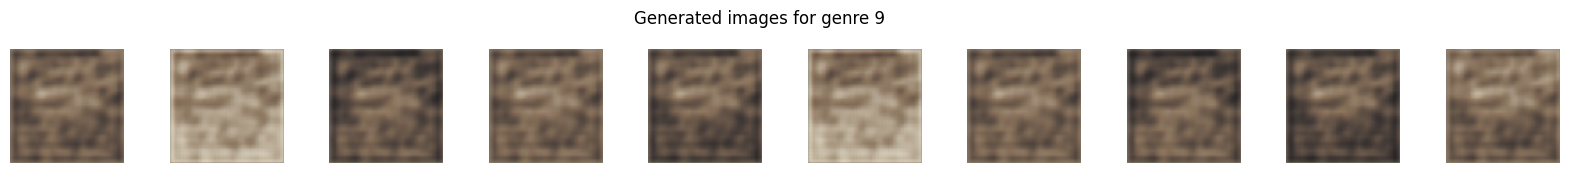

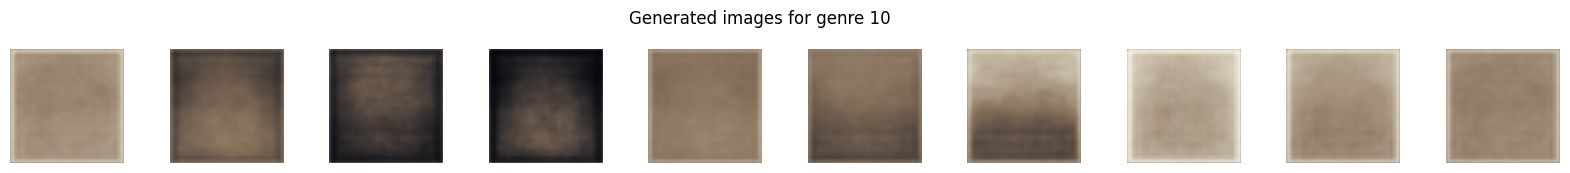

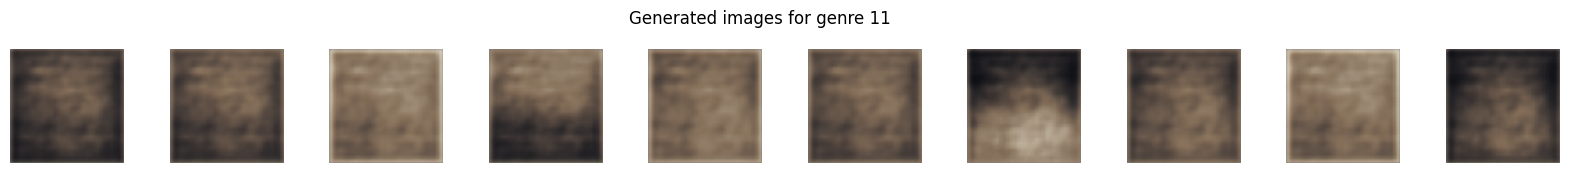

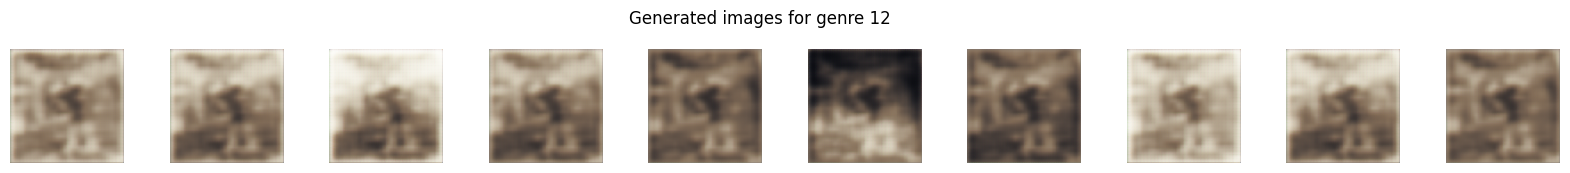

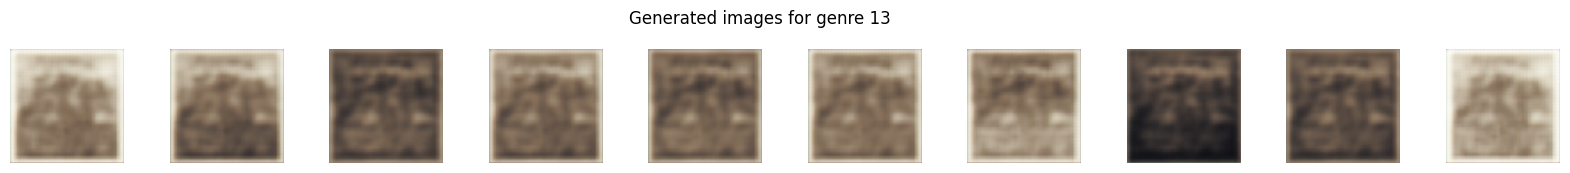

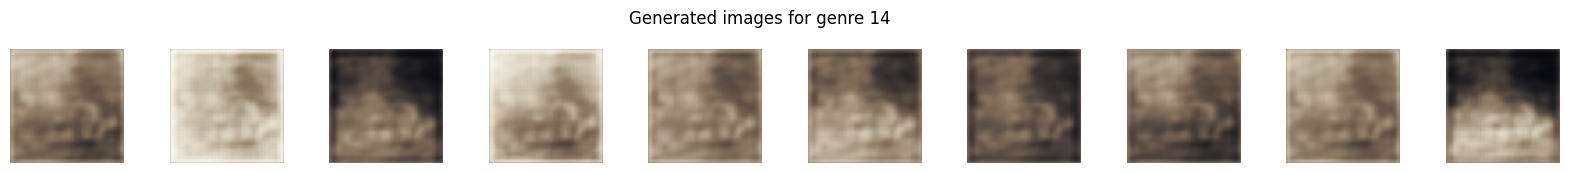

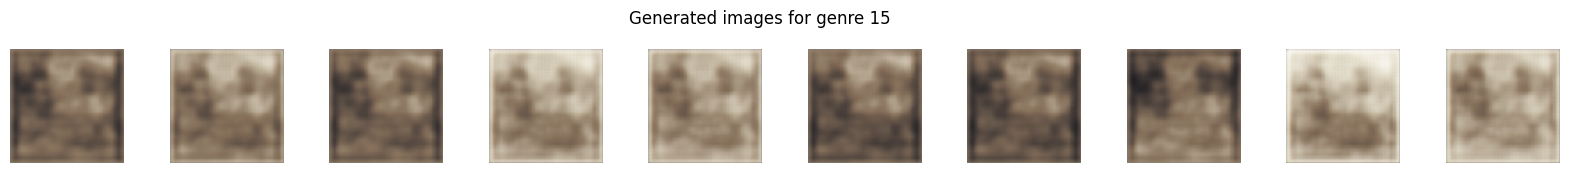

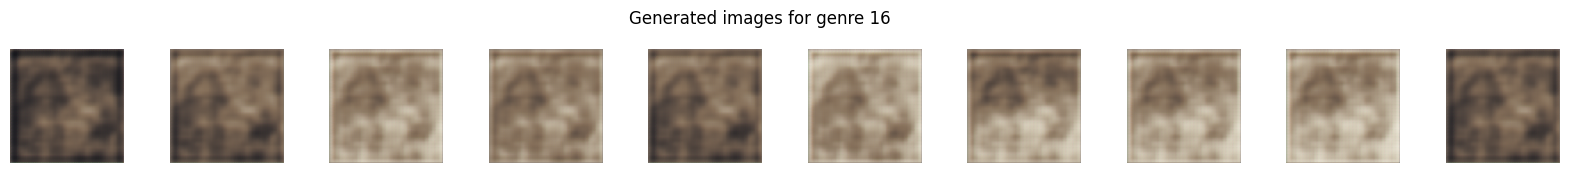

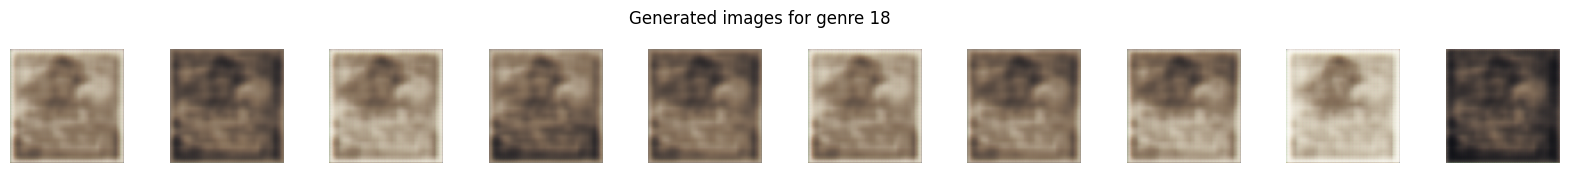

In [42]:
# Função para gerar novas imagens condicionadas pelo gênero
def generate_images(cvae, genres, num_images=10): #Função para gerar 10 imagens condicionadas pelo género
    z_sample = np.random.normal(size=(num_images, cvae.z_dim))
    generated_images = cvae.decoder.predict([z_sample, genres])
    return generated_images

# Exemplos de imagens geradas para cada gênero
for genre_idx in range(y_train.shape[1]): #Loop para gerar imagens para cada género
    genre_label = np.zeros((1, y_train.shape[1])) #Cria um array de zeros para o género
    genre_label[0, genre_idx] = 1 #Atribui 1 ao género que queremos gerar imagens
    genre_labels = np.repeat(genre_label, n_to_test, axis=0) #Repete o género para gerar 10 imagens

    generated_images = generate_images(cvae, genre_labels, num_images=n_to_test) 

    fig = plt.figure(figsize=(20, 2)) 
    fig.subplots_adjust(hspace=0.4, wspace=0.4) 
    for i in range(n_to_test): #Loop para mostrar as imagens geradas
        ax = fig.add_subplot(1, n_to_test, i+1)  #Adiciona a imagem ao plot, com o título do género e com o género correspondente ao índice
        ax.axis('off')
        ax.imshow(generated_images[i])
    plt.suptitle(f'Generated images for genre {genre_idx}')    
    plt.show()